## Import libraries


Ref:
1.  https://github.com/marsuconn/sioux-falls-network/tree/master
2. https://github.com/bstabler/TransportationNetworks
3. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9792244
4. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10695073



In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import os
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format  # Display only 2 decimal points

## Create Graph network


In [22]:
net= pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
flow=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization

In [23]:
# dataframe containing all link attributes
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",6,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",4,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",6,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",5,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",4,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",4,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",2,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",4,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",3,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [24]:
sioux_falls_df['length'] *= 5
print("Updated DataFrame:")
sioux_falls_df

Updated DataFrame:


,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",30,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",20,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",30,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",25,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",20,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",20,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",10,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",20,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",15,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [42]:
def create_graph(sioux_falls_df):
    # Create graph

    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for n, p in pos_coord.items():
        G.nodes[n]['pos_coord'] = p

    for n, p in pos_xy.items():
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {2, 6, 12, 16}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = n in charging_stations

    return G, pos_xy, charging_stations

In [43]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('sioux-falls-network.png')
    plt.show()

In [44]:
def find_all_paths(graph, start_state, goal_state):
    paths = list(nx.all_simple_paths(graph, source=start_state, target=goal_state))
    path_distances = []
    for idx, path in enumerate(paths, start=1):
        distance = sum(graph[path[i]][path[i + 1]][0]['length'] for i in range(len(path) - 1) if graph[path[i]][path[i + 1]])
        path_distances.append((idx, path, distance))
    return path_distances

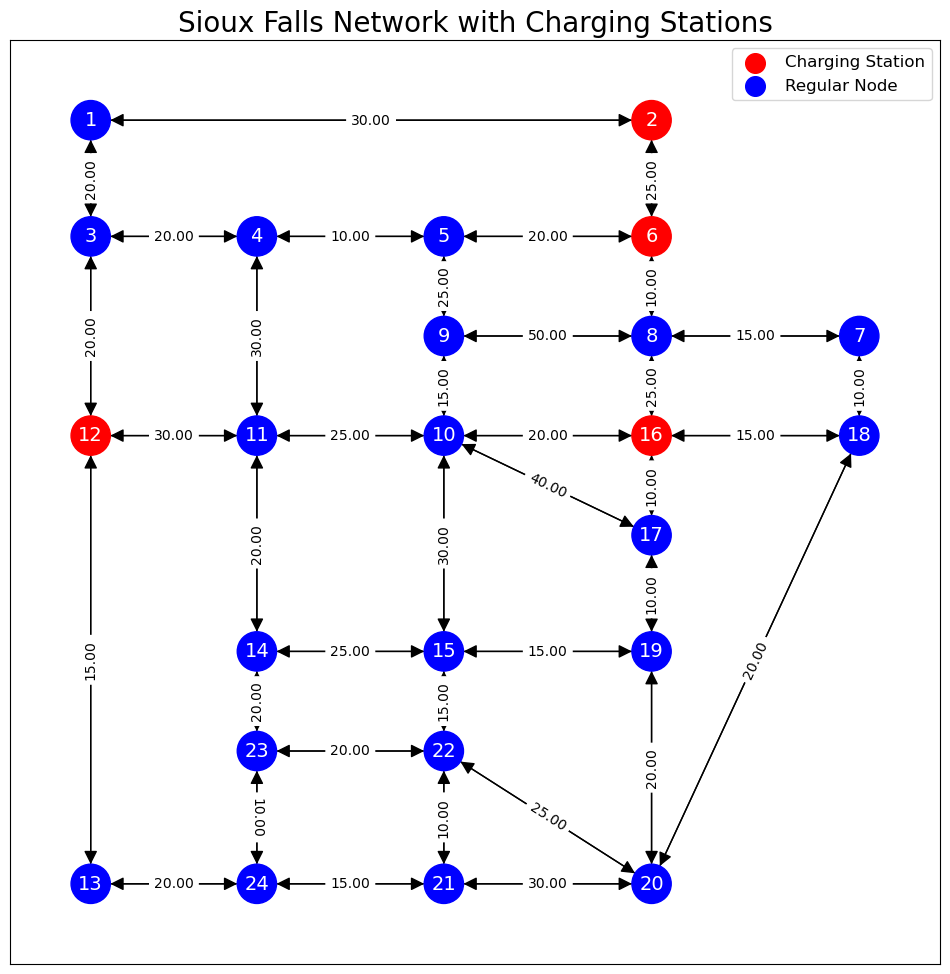

In [45]:
# Execution
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

In [46]:
all_paths = find_all_paths(G, start_state=1, goal_state=24)
print("\nAll paths from node 1 to 24 and their distances:")
for idx, path, distance in all_paths:
    print(f"Path {idx}: {path}, Distance: {distance:.2f}")


All paths from node 1 to 24 and their distances:
Path 1: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 22, 20, 21, 24], Distance: 455.00
Path 2: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 22, 21, 24], Distance: 410.00
Path 3: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 24], Distance: 375.00
Path 4: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 20, 21, 24], Distance: 405.00
Path 5: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 21, 24], Distance: 360.00
Path 6: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 23, 24], Distance: 365.00
Path 7: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 22, 15, 14, 23, 24], Distance: 435.00
Path 8: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 22, 23, 24], Distance: 395.00
Path 9: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 24], Distance: 370.00
Path 10: [1, 2, 6, 5, 4, 3, 12, 

##RL Implementation

In [47]:
# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Hyperparameters for the Q-learning algorithm
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate (initially set to 1 for maximum exploration)
epsilon_decay = 0.995  # Decay rate for epsilon (reduces exploration over time)
epsilon_min = 0.01  # Minimum value for epsilon (ensures some exploration)
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 1000 # Maximum steps allowed per episode

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50 # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5 # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

# Properties of charging stations (station ID: (charging time, waiting time))
charging_station_properties = {
    2: (30, 10) , 6: (35, 15),
    12: (20, 10), 16: (30, 5)
}

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
# Map node IDs to zero-based indices
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}


destination_node =24

##Q learning v3

In [48]:
# Initialize Q-tables
num_states = G.number_of_nodes()
num_actions = G.number_of_nodes()
Q_layer1 = np.zeros((num_states, num_actions))
Q_layer2 = np.zeros((num_states, len(charging_stations)))

def get_state(current_node, SoC):
    return current_node

def choose_action_layer1(state, SoC):
    valid_actions = list(G.neighbors(state))

    # Filter out actions that lead to already visited nodes
    unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

    if unexplored_actions:  # If there are unexplored actions, prioritize them
        valid_actions = unexplored_actions

    if np.random.rand() <= epsilon:
        return random.choice(valid_actions)  # Exploration: choose a random valid action
    else:
        # Exploitation: choose the action with the highest Q-value
        valid_q_values = {action: Q_layer1[node_to_index[state], node_to_index[action]] for action in valid_actions}
        return max(valid_q_values, key=valid_q_values.get)

def choose_action_layer2(state):
    if np.random.rand() <= epsilon:
        return random.choice(list(charging_stations))
    else:
        valid_q_values = {station: Q_layer2[node_to_index[state], charging_station_index[station]] for station in charging_stations}
        return max(valid_q_values, key=valid_q_values.get)

def calculate_travel_time(distance):
    return (distance / average_velocity) * 60

def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Increased penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 500  # Increased penalty for revisiting nodes

    # Add a penalty based on the distance to the destination
    shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
    reward -= shortest_path_distance * 0.1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    return next_node, SoC, reward, total_time

def step_layer2(action, current_node, SoC, path):
    # Calculate the distance to the charging station
    distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    if SoC < required_SoC:
        # Impose a heavy penalty if the SoC is insufficient
        reward = -1000  # Heavy penalty for not being able to reach the charging station
        total_time = 0  # No time is spent since the vehicle cannot move
        next_node = current_node  # Stay at the current node
        return next_node, SoC, reward, total_time

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time)
    reward = -total_time

    # Set the next node to the charging station
    next_node = action

    return next_node, SoC, reward, total_time

episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()  # Track visited nodes
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)
        if SoC <= 30:
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, reward_layer2, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
            total_time += time_taken_layer2
            action_idx = charging_station_index[action_layer2]
            next_state_layer2 = get_state(next_node, SoC)
            Q_layer2[node_to_index[state], action_idx] += alpha * (reward_layer2 + gamma * np.max(Q_layer2[node_to_index[next_state_layer2]]) - Q_layer2[node_to_index[state], action_idx])
            episode_reward += reward_layer2
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, reward_layer1, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
            total_time += time_taken_layer1
            next_state_layer1 = get_state(next_node, SoC)
            Q_layer1[node_to_index[state], node_to_index[action_layer1]] += alpha * (reward_layer1 + gamma * np.max(Q_layer1[node_to_index[next_state_layer1]]) - Q_layer1[node_to_index[state], node_to_index[action_layer1]])
            episode_reward += reward_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")


    # Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)
    if SoC <= 30:
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
        total_time += time_taken_layer2
        charging_stations_visited[action_layer2] = time_taken_layer2
    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
        total_time += time_taken_layer1

    # Additional penalty for staying at the same node
    if next_node == current_node:
        total_time += 10  # Additional penalty for staying at the same node

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

Episode: 0, Total Time: 676.6666666666666, Episode Reward: -5746.166666666668
Episode: 1, Total Time: 836.6666666666665, Episode Reward: -6965.666666666668
Episode: 2, Total Time: 2790.0000000000014, Episode Reward: -53747.00000000001
Episode: 3, Total Time: 1528.3333333333337, Episode Reward: -20830.833333333336
Episode: 4, Total Time: 634.9999999999999, Episode Reward: -5719.0
Episode: 5, Total Time: 366.6666666666667, Episode Reward: -8393.166666666666
Episode: 6, Total Time: 1063.3333333333333, Episode Reward: -13700.833333333334
Episode: 7, Total Time: 709.9999999999999, Episode Reward: -982304.5
Episode: 8, Total Time: 243.33333333333331, Episode Reward: -265.3333333333333
Episode: 9, Total Time: 728.3333333333333, Episode Reward: -8330.833333333334
Episode: 10, Total Time: 646.6666666666667, Episode Reward: -8225.166666666666
Episode: 11, Total Time: 696.6666666666666, Episode Reward: -10822.166666666666
Episode: 12, Total Time: 563.3333333333333, Episode Reward: -6150.333333333

Episode: 115, Total Time: 1043.3333333333335, Episode Reward: -976233.8333333334
Episode: 116, Total Time: 821.6666666666666, Episode Reward: -5427.666666666667
Episode: 117, Total Time: 2760.0000000000005, Episode Reward: -24677.499999999996
Episode: 118, Total Time: 130.0, Episode Reward: -141.0
Episode: 119, Total Time: 646.6666666666666, Episode Reward: -2234.1666666666665
Episode: 120, Total Time: 396.6666666666667, Episode Reward: -944.6666666666666
Episode: 121, Total Time: 130.0, Episode Reward: -1141.0
Episode: 122, Total Time: 856.6666666666665, Episode Reward: -3468.1666666666665
Episode: 123, Total Time: 628.3333333333333, Episode Reward: -4218.333333333334
Episode: 124, Total Time: 130.0, Episode Reward: -141.0
Episode: 125, Total Time: 458.3333333333333, Episode Reward: -3540.833333333334
Episode: 126, Total Time: 673.3333333333334, Episode Reward: -980771.8333333333
Episode: 127, Total Time: 1093.3333333333337, Episode Reward: -8294.833333333332
Episode: 128, Total Time:

Episode: 241, Total Time: 485.0, Episode Reward: -986547.0
Episode: 242, Total Time: 855.0000000000001, Episode Reward: -6973.999999999999
Episode: 243, Total Time: 1004.9999999999999, Episode Reward: -6113.500000000001
Episode: 244, Total Time: 633.3333333333334, Episode Reward: -1252.3333333333333
Episode: 245, Total Time: 1231.666666666667, Episode Reward: -6912.666666666666
Episode: 246, Total Time: 286.6666666666667, Episode Reward: -991847.1666666666
Episode: 247, Total Time: 469.99999999999994, Episode Reward: -540.0
Episode: 248, Total Time: 476.6666666666666, Episode Reward: -1549.1666666666665
Episode: 249, Total Time: 286.6666666666667, Episode Reward: -991847.1666666667
Episode: 250, Total Time: 978.3333333333334, Episode Reward: -5132.333333333333
Episode: 251, Total Time: 561.6666666666666, Episode Reward: -1656.1666666666667
Episode: 252, Total Time: 861.6666666666667, Episode Reward: -979020.1666666667
Episode: 253, Total Time: 275.0, Episode Reward: -316.0
Episode: 254

Episode: 399, Total Time: 190.0, Episode Reward: -207.99999999999997
Episode: 400, Total Time: 130.0, Episode Reward: -141.0
Episode: 401, Total Time: 130.0, Episode Reward: -1141.0
Episode: 402, Total Time: 130.0, Episode Reward: -141.0
Episode: 403, Total Time: 130.0, Episode Reward: -141.0
Episode: 404, Total Time: 130.0, Episode Reward: -141.0
Episode: 405, Total Time: 130.0, Episode Reward: -141.0
Episode: 406, Total Time: 130.0, Episode Reward: -141.0
Episode: 407, Total Time: 130.0, Episode Reward: -1141.0
Episode: 408, Total Time: 130.0, Episode Reward: -141.0
Episode: 409, Total Time: 130.0, Episode Reward: -141.0
Episode: 410, Total Time: 130.0, Episode Reward: -141.0
Episode: 411, Total Time: 525.0, Episode Reward: -603.9999999999999
Episode: 412, Total Time: 130.0, Episode Reward: -141.0
Episode: 413, Total Time: 130.0, Episode Reward: -141.0
Episode: 414, Total Time: 130.0, Episode Reward: -141.0
Episode: 415, Total Time: 130.0, Episode Reward: -1141.0
Episode: 416, Total 

Episode: 897, Total Time: 130.0, Episode Reward: -141.0
Episode: 898, Total Time: 130.0, Episode Reward: -141.0
Episode: 899, Total Time: 130.0, Episode Reward: -141.0
Episode: 900, Total Time: 130.0, Episode Reward: -141.0
Episode: 901, Total Time: 130.0, Episode Reward: -141.0
Episode: 902, Total Time: 130.0, Episode Reward: -141.0
Episode: 903, Total Time: 130.0, Episode Reward: -141.0
Episode: 904, Total Time: 130.0, Episode Reward: -141.0
Episode: 905, Total Time: 130.0, Episode Reward: -141.0
Episode: 906, Total Time: 130.0, Episode Reward: -141.0
Episode: 907, Total Time: 130.0, Episode Reward: -141.0
Episode: 908, Total Time: 130.0, Episode Reward: -141.0
Episode: 909, Total Time: 130.0, Episode Reward: -141.0
Episode: 910, Total Time: 130.0, Episode Reward: -141.0
Episode: 911, Total Time: 130.0, Episode Reward: -141.0
Episode: 912, Total Time: 130.0, Episode Reward: -141.0
Episode: 913, Total Time: 130.0, Episode Reward: -141.0
Episode: 914, Total Time: 130.0, Episode Reward:

##Q learning without deviation

In [49]:
# Initialize Q-tables
num_states = G.number_of_nodes()
num_actions = G.number_of_nodes()
Q_layer1 = np.zeros((num_states, num_actions))
Q_layer2 = np.zeros((num_states, len(charging_stations)))

def get_state(current_node, SoC):
    return current_node

def choose_action_layer1(state, SoC):
    valid_actions = list(G.neighbors(state))

    # Filter out actions that lead to already visited nodes
    unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

    if unexplored_actions:  # If there are unexplored actions, prioritize them
        valid_actions = unexplored_actions

    if np.random.rand() <= epsilon:
        return random.choice(valid_actions)  # Exploration: choose a random valid action
    else:
        # Exploitation: choose the action with the highest Q-value
        valid_q_values = {action: Q_layer1[node_to_index[state], node_to_index[action]] for action in valid_actions}
        return max(valid_q_values, key=valid_q_values.get)

def choose_action_layer2(state):
    if np.random.rand() <= epsilon:
        return random.choice(list(charging_stations))
    else:
        valid_q_values = {station: Q_layer2[node_to_index[state], charging_station_index[station]] for station in charging_stations}
        return max(valid_q_values, key=valid_q_values.get)

def calculate_travel_time(distance):
    return (distance / average_velocity) * 60

def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Increased penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 500  # Increased penalty for revisiting nodes

    # Add a penalty based on the distance to the destination
    shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
    reward -= shortest_path_distance*0.1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    return next_node, SoC, reward, total_time

def step_layer2(action, current_node, SoC, path):
    # Calculate the distance to the charging station
    distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    if SoC < required_SoC:
        # Impose a heavy penalty if the SoC is insufficient
        reward = -1000  # Heavy penalty for not being able to reach the charging station
        total_time = 0  # No time is spent since the vehicle cannot move
        next_node = current_node  # Stay at the current node
        return next_node, SoC, reward, total_time

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time)
    reward = -total_time

    # Set the next node to the charging station
    next_node = action

    return next_node, SoC, reward, total_time

episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()  # Track visited nodes
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)
        if SoC <= 30:
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, reward_layer2, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
            total_time += time_taken_layer2
            action_idx = charging_station_index[action_layer2]
            next_state_layer2 = get_state(next_node, SoC)
            Q_layer2[node_to_index[state], action_idx] += alpha * (reward_layer2 + gamma * np.max(Q_layer2[node_to_index[next_state_layer2]]) - Q_layer2[node_to_index[state], action_idx])
            episode_reward += reward_layer2
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, reward_layer1, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
            total_time += time_taken_layer1
            next_state_layer1 = get_state(next_node, SoC)
            Q_layer1[node_to_index[state], node_to_index[action_layer1]] += alpha * (reward_layer1 + gamma * np.max(Q_layer1[node_to_index[next_state_layer1]]) - Q_layer1[node_to_index[state], node_to_index[action_layer1]])
            episode_reward += reward_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")


    # Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)
    if SoC <= 30:
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
        total_time += time_taken_layer2
        charging_stations_visited[action_layer2] = time_taken_layer2
    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
        total_time += time_taken_layer1

    # Additional penalty for staying at the same node
    if next_node == current_node:
        total_time += 10  # Additional penalty for staying at the same node

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

q_learning_total_time = total_time
path_q_learning = path
print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")


# Print Q-tables
print("Q-Layer1 Table:")
print(Q_layer1)
print("Q-Layer2 Table:")
print(Q_layer2)

# Save Q-tables as CSV files
pd.DataFrame(Q_layer1).to_csv("Q_layer1.csv", index=False)
pd.DataFrame(Q_layer2).to_csv("Q_layer2.csv", index=False)

Episode: 0, Total Time: 1005.0000000000001, Episode Reward: -6641.5
Episode: 1, Total Time: 486.66666666666663, Episode Reward: -988547.6666666667
Episode: 2, Total Time: 521.6666666666666, Episode Reward: -989128.6666666667
Episode: 3, Total Time: 1361.666666666667, Episode Reward: -12581.666666666666
Episode: 4, Total Time: 183.33333333333331, Episode Reward: -198.33333333333331
Episode: 5, Total Time: 130.0, Episode Reward: -141.0
Episode: 6, Total Time: 426.6666666666667, Episode Reward: -3473.6666666666665
Episode: 7, Total Time: 688.3333333333334, Episode Reward: -978799.3333333334
Episode: 8, Total Time: 646.6666666666667, Episode Reward: -3225.1666666666665
Episode: 9, Total Time: 871.6666666666664, Episode Reward: -4986.166666666669
Episode: 10, Total Time: 703.3333333333334, Episode Reward: -980318.8333333334
Episode: 11, Total Time: 183.33333333333331, Episode Reward: -198.33333333333331
Episode: 12, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode:

Episode: 133, Total Time: 1261.6666666666667, Episode Reward: -970458.1666666666
Episode: 134, Total Time: 841.6666666666667, Episode Reward: -3980.666666666667
Episode: 135, Total Time: 868.3333333333333, Episode Reward: -4010.833333333333
Episode: 136, Total Time: 868.3333333333333, Episode Reward: -4010.833333333333
Episode: 137, Total Time: 663.3333333333335, Episode Reward: -1765.3333333333333
Episode: 138, Total Time: 1310.0000000000002, Episode Reward: -970525.0
Episode: 139, Total Time: 475.0, Episode Reward: -985067.5
Episode: 140, Total Time: 475.0, Episode Reward: -985067.5
Episode: 141, Total Time: 819.9999999999999, Episode Reward: -1962.0000000000002
Episode: 142, Total Time: 1541.6666666666665, Episode Reward: -963843.1666666667
Episode: 143, Total Time: 768.3333333333334, Episode Reward: -2377.833333333333
Episode: 144, Total Time: 768.3333333333334, Episode Reward: -1377.8333333333335
Episode: 145, Total Time: 605.0000000000001, Episode Reward: -1207.0
Episode: 146, To

Episode: 237, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 238, Total Time: 755.0, Episode Reward: -1360.0000000000002
Episode: 239, Total Time: 768.3333333333333, Episode Reward: -1868.8333333333335
Episode: 240, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 241, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 242, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 243, Total Time: 755.0, Episode Reward: -1360.0000000000002
Episode: 244, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 245, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 246, Total Time: 755.0, Episode Reward: -1360.0000000000002
Episode: 247, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 248, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episode: 249, Total Time: 755.0, Episode Reward: -4360.000000000001
Episode: 250, Total Time: 645.0000000000001, Episode Reward: -980254.0
Episo

Episode: 383, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 384, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 385, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 386, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 387, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 388, Total Time: 350.00000000000006, Episode Reward: -1907.5
Episode: 389, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 390, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 391, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 392, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 393, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 394, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 395, Total Time: 350.000000000

Episode: 619, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 620, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 621, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 622, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 623, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 624, Total Time: 468.33333333333337, Episode Reward: -1047.3333333333333
Episode: 625, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 626, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 627, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 628, Total Time: 501.6666666666667, Episode Reward: -1077.6666666666665
Episode: 629, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 630, Total Time: 350.00000000000006, Episode Reward: -907.4999999999999
Episode: 631, Total Time: 3

Episode: 849, Total Time: 435.0, Episode Reward: -1004.5
Episode: 850, Total Time: 435.0, Episode Reward: -1004.5
Episode: 851, Total Time: 435.0, Episode Reward: -1004.5
Episode: 852, Total Time: 435.0, Episode Reward: -1004.5
Episode: 853, Total Time: 435.0, Episode Reward: -1004.5
Episode: 854, Total Time: 435.0, Episode Reward: -1004.5
Episode: 855, Total Time: 435.0, Episode Reward: -1004.5
Episode: 856, Total Time: 435.0, Episode Reward: -1004.5
Episode: 857, Total Time: 435.0, Episode Reward: -1004.5
Episode: 858, Total Time: 435.0, Episode Reward: -1004.5
Episode: 859, Total Time: 435.0, Episode Reward: -1004.5
Episode: 860, Total Time: 435.0, Episode Reward: -1004.5
Episode: 861, Total Time: 435.0, Episode Reward: -1004.5
Episode: 862, Total Time: 435.0, Episode Reward: -1004.5
Episode: 863, Total Time: 435.0, Episode Reward: -1004.5
Episode: 864, Total Time: 435.0, Episode Reward: -1004.5
Episode: 865, Total Time: 435.0, Episode Reward: -1004.5
Episode: 866, Total Time: 435.0

In [50]:
print(Q_layer1.shape, Q_layer2.shape)

(24, 24) (24, 4)


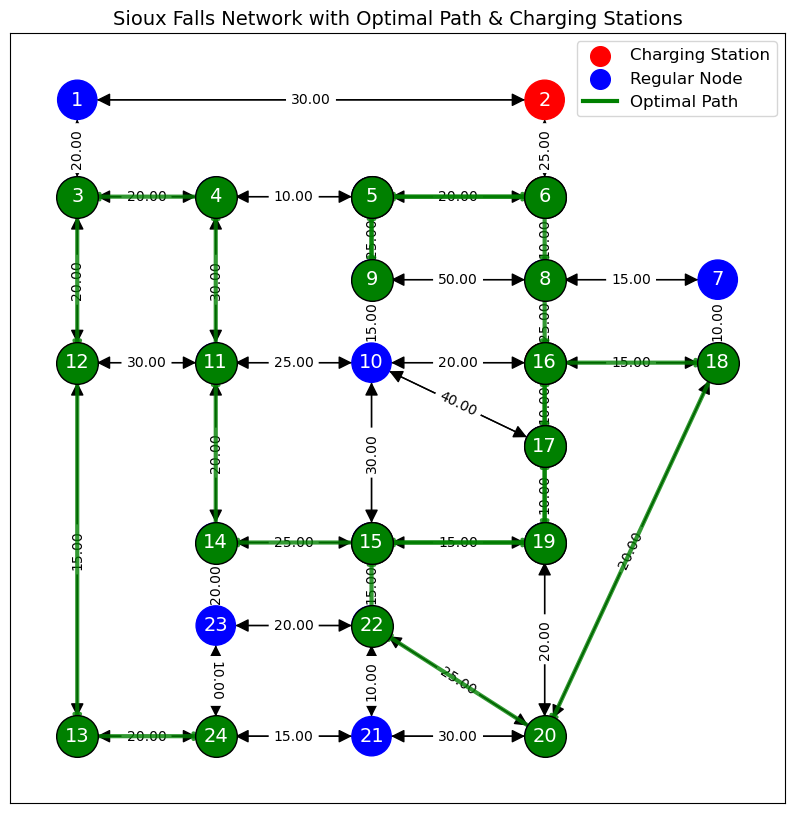

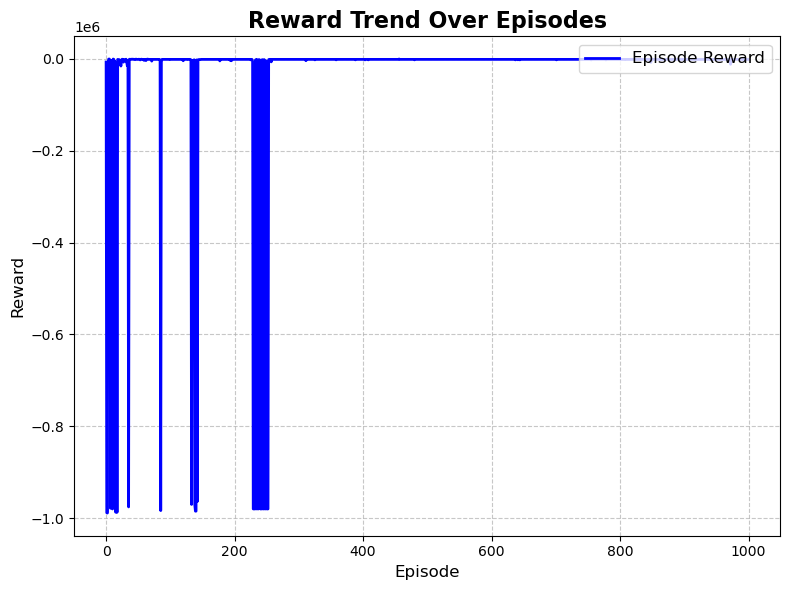

In [51]:
def plot_graph_with_path(G, pos, path):
    """
    Plots the Sioux Falls network with charging stations and highlights the optimal path.

    Args:
        G (networkx.Graph): The graph object.
        pos (dict): A dictionary mapping node IDs to positions.
        path (list): The optimal path as a list of nodes.
    """
    plt.figure(figsize=(10, 10))

    # Define node colors (red for charging stations, blue otherwise)
    node_colors = ['red' if G.nodes[n].get('charging_station', False) else 'blue' for n in G.nodes]

    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Highlight the optimal path in red
    path_edges = list(zip(path[:-1], path[1:]))  # Extract edges from path
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3, alpha=0.8, label="Optimal Path")
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=900, node_color="green", edgecolors="black")

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.plot([], [], color="green", linewidth=3, label="Optimal Path")  # Line for path in legend
    plt.legend(loc='upper right', fontsize=12)

    # Title and layout
    plt.title('Sioux Falls Network with Optimal Path & Charging Stations', fontsize=14)
    plt.savefig('sioux-falls-network-optimal-path.png')
    plt.show()

# Function to plot the reward trend over episodes
def plot_reward_trend(episode_rewards):
    """
    Plots the reward trend over episodes.

    Args:
        episode_rewards (list): A list of rewards for each episode.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(episode_rewards)), episode_rewards, label="Episode Reward", color="blue", linewidth=2)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.title("Reward Trend Over Episodes", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
plot_graph_with_path(G, pos, path)
# 2. Plot the reward trend over episodes
plot_reward_trend(episode_rewards)


##A*heuristics

In [52]:
import heapq


def a_star(G, start_node, destination_node, initial_SoC, charging_stations, SoC_consumption_rate, max_cap, charging_capacity):
    open_set = []
    heapq.heappush(open_set, (0, start_node, initial_SoC, 0, [start_node], {}))  # (f, node, SoC, g, path, charging_stations_visited)

    visited = {}  # Key: (node, SoC), Value: g value (time taken so far)
    visited[(start_node, initial_SoC)] = 0

    while open_set:
        f, current_node, SoC, g, path, charging_stations_visited = heapq.heappop(open_set)

        if current_node == destination_node:
            return path, g, charging_stations_visited

        for neighbor in G.neighbors(current_node):
            edge_key = next(iter(G[current_node][neighbor]))
            distance = G[current_node][neighbor][edge_key]['length']
            travel_time = calculate_travel_time(distance)
            new_SoC = SoC - distance * SoC_consumption_rate

            if new_SoC < 0:
                continue  # Skip if not enough SoC to reach the neighbor

            new_g = g + travel_time
            new_f = new_g + heuristic(G, neighbor, destination_node)

            if (neighbor, new_SoC) not in visited or new_g < visited[(neighbor, new_SoC)]:
                visited[(neighbor, new_SoC)] = new_g
                heapq.heappush(open_set, (new_f, neighbor, new_SoC, new_g, path + [neighbor], charging_stations_visited))

        # Consider charging at a charging station if SoC is low
        if SoC <= 30:
            for station in charging_stations:
                distance_to_station = nx.shortest_path_length(G, source=current_node, target=station, weight='length')
                required_SoC = distance_to_station * SoC_consumption_rate

                if SoC < required_SoC:
                    continue  # Skip if not enough SoC to reach the charging station

                path_to_station = nx.shortest_path(G, source=current_node, target=station, weight='length')
                travel_time_to_station = calculate_travel_time(distance_to_station)
                charging_time, waiting_time = charging_station_properties[station]
                total_time_to_station = travel_time_to_station + charging_time + waiting_time
                new_SoC_after_charging = min(max_cap, SoC - distance_to_station * SoC_consumption_rate + charging_capacity)

                new_g = g + total_time_to_station
                new_f = new_g + heuristic(G, station, destination_node)

                # Update charging stations visited
                updated_charging_stations_visited = charging_stations_visited.copy()
                updated_charging_stations_visited[station] = total_time_to_station

                if (station, new_SoC_after_charging) not in visited or new_g < visited[(station, new_SoC_after_charging)]:
                    visited[(station, new_SoC_after_charging)] = new_g
                    heapq.heappush(open_set, (new_f, station, new_SoC_after_charging, new_g, path + path_to_station[1:], updated_charging_stations_visited))

    return None, float('inf'), {}  # No path found

# Heuristic function (shortest path distance)
def heuristic(G, node, destination_node):
    return nx.shortest_path_length(G, source=node, target=destination_node, weight='length')

# Testing the A* algorithm
start_node = 6
destination_node = 24
initial_SoC = 50
SoC_consumption_rate = 0.5
max_cap = 100
charging_capacity = 50

path, total_time, charging_stations_visited_a_star = a_star(G, start_node, destination_node, initial_SoC, charging_stations, SoC_consumption_rate, max_cap, charging_capacity)

if path:
    print("A* Algorithm Results:")
    print("Optimal Path:", path)
    print("Total Time to Reach Destination:", total_time, "minutes")
    if charging_stations_visited_a_star:
        print("Charging Stations Visited and Time Spent:")
        for station, time_spent in charging_stations_visited_a_star.items():
            print(f"Charging Station {station}: {time_spent} minutes")
    else:
        print("No Charging Stations Visited.")
else:
    print("No path found.")

A* Algorithm Results:
Optimal Path: [6, 8, 7, 18, 20, 21, 24]
Total Time to Reach Destination: 133.33333333333331 minutes
No Charging Stations Visited.


## DQN

In [53]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.memory_allocated())

True
0
Tesla V100-SXM2-16GB
1380352


In [54]:
import numpy as np
import random
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.9  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions, visited_nodes):
        if np.random.rand() <= self.epsilon:
            filtered_actions = [a for a in valid_actions if a not in visited_nodes]
            return random.choice(filtered_actions) if filtered_actions else None

        state = torch.FloatTensor(state)
        act_values = self.model(state).detach().numpy()

        # Filter valid actions within model's action space and not in visited_nodes
        valid_q_values = {action: act_values[action] for action in valid_actions if action not in visited_nodes and action < len(act_values)}

        if not valid_q_values:
            return None  # No valid actions left

        return max(valid_q_values, key=valid_q_values.get)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)))
            target_f = self.model(state).clone().detach()

            if action < len(target_f):
                target_f[action] = target

            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Function to convert node index to one-hot encoded state
def get_state(current_node, num_states):
    state = np.zeros(num_states)
    state[current_node - 1] = 1  # Convert to zero-based index
    return state

# Initialize the DQN agents for both layers
state_size = num_states
action_size_layer1 = num_actions
action_size_layer2 = len(charging_stations)
agent_layer1 = DQNAgent(state_size, action_size_layer1)
agent_layer2 = DQNAgent(state_size, action_size_layer2)

# Training the DQN agents
batch_size = 32
episode_rewards = []

for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, state_size)

        if SoC < 30:
            valid_actions = list(charging_stations)
            action = agent_layer2.choose_action(state, valid_actions, visited_nodes)
            if action is None:
                break  # No valid actions left
            next_node, SoC, reward, time_taken = step_layer2(action, current_node, SoC, path)
        else:
            valid_actions = list(G.neighbors(current_node))
            action = agent_layer1.choose_action(state, valid_actions, visited_nodes)
            if action is None:
                break  # No valid actions left
            next_node, SoC, reward, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)

        total_time += time_taken
        next_state = get_state(next_node, state_size)
        done = (next_node == destination_node)

        agent_layer1.remember(state, action, reward, next_state, done) if SoC >= 30 else agent_layer2.remember(state, action, reward, next_state, done)
        episode_reward += reward

        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    if len(agent_layer1.memory) > batch_size:
        agent_layer1.replay(batch_size)
    if len(agent_layer2.memory) > batch_size:
        agent_layer2.replay(batch_size)

    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, state_size)

    if SoC < 30:
        valid_actions = list(charging_stations)
        action = agent_layer2.choose_action(state, valid_actions, visited_nodes)
        if action is None:
            break  # No valid actions left
        next_node, SoC, _, time_taken = step_layer2(action, current_node, SoC, path)
        total_time += time_taken
        charging_stations_visited[action] = time_taken
    else:
        valid_actions = list(G.neighbors(current_node))
        action = agent_layer1.choose_action(state, valid_actions, visited_nodes)
        if action is None:
            break  # No valid actions left
        next_node, SoC, _, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)
        total_time += time_taken

    if not (path and path[-1] == next_node):
        path.append(next_node)

    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

Episode: 0, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 1, Total Time: 288.3333333333333, Episode Reward: -32334.833333333332
Episode: 2, Total Time: 393.33333333333337, Episode Reward: -464.83333333333337
Episode: 3, Total Time: 631.6666666666666, Episode Reward: -4719.666666666667
Episode: 4, Total Time: 176.66666666666666, Episode Reward: -1208.6666666666667
Episode: 5, Total Time: 308.33333333333337, Episode Reward: -49359.833333333336
Episode: 6, Total Time: 209.99999999999997, Episode Reward: -233.49999999999997
Episode: 7, Total Time: 281.6666666666667, Episode Reward: -238332.16666666666
Episode: 8, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 9, Total Time: 209.99999999999997, Episode Reward: -5230.0
Episode: 10, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 11, Total Time: 491.66666666666663, Episode Reward: -562.1666666666667
Episode: 12, Total Time: 209.99999999999997, Episode Reward: 

Episode: 110, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 111, Total Time: 275.0, Episode Reward: -318.00000000000006
Episode: 112, Total Time: 250.00000000000006, Episode Reward: -304.0
Episode: 113, Total Time: 275.0, Episode Reward: -4327.0
Episode: 114, Total Time: 451.6666666666666, Episode Reward: -522.6666666666666
Episode: 115, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 116, Total Time: 183.33333333333331, Episode Reward: -1203.3333333333333
Episode: 117, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 118, Total Time: 335.00000000000006, Episode Reward: -403.5
Episode: 119, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 120, Total Time: 209.99999999999997, Episode Reward: -2229.9999999999995
Episode: 121, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 122, Total Time: 73.33333333333334, Episode Reward: -2093.833333333333
Episode: 123

Episode: 215, Total Time: 250.00000000000003, Episode Reward: -302.0
Episode: 216, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 217, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 218, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 219, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 220, Total Time: 209.99999999999997, Episode Reward: -42229.99999999999
Episode: 221, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 222, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 223, Total Time: 288.33333333333337, Episode Reward: -1337.8333333333335
Episode: 224, Total Time: 345.0, Episode Reward: -389.5
Episode: 225, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 226, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 227, Total Time: 73.33333333333334, Episode Reward: -93.8333333

Episode: 322, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 323, Total Time: 183.33333333333331, Episode Reward: -4203.333333333333
Episode: 324, Total Time: 275.0, Episode Reward: -320.0
Episode: 325, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 326, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 327, Total Time: 263.3333333333333, Episode Reward: -311.8333333333333
Episode: 328, Total Time: 73.33333333333334, Episode Reward: -1093.8333333333333
Episode: 329, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 330, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 331, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 332, Total Time: 275.0, Episode Reward: -320.0
Episode: 333, Total Time: 183.33333333333331, Episode Reward: -9203.333333333332
Episode: 334, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episo

Episode: 426, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 427, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 428, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 429, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 430, Total Time: 73.33333333333334, Episode Reward: -93.83333333333334
Episode: 431, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 432, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 433, Total Time: 73.33333333333333, Episode Reward: -997084.3333333333
Episode: 434, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 435, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 436, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 437, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 438, Total Time: 306.6666666666

Episode: 529, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 530, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 531, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 532, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 533, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 534, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 535, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 536, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 537, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 538, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 539, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 540, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 541, Total Time: 93.33333333333

Episode: 632, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 633, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 634, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 635, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 636, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 637, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 638, Total Time: 306.6666666666667, Episode Reward: -368.1666666666667
Episode: 639, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 640, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 641, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 642, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 643, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 644, Total Time: 93.33333333333

Episode: 735, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 736, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 737, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 738, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 739, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 740, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 741, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 742, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 743, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 744, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 745, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 746, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 747, Total Time: 93.33333333333

Episode: 838, Total Time: 73.33333333333333, Episode Reward: -997084.3333333333
Episode: 839, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 840, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 841, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 842, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 843, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 844, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 845, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 846, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 847, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 848, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 849, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 850, Total Time: 93.33333333333

Episode: 941, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 942, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 943, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 944, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 945, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 946, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 947, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 948, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 949, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 950, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 951, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 952, Total Time: 93.33333333333333, Episode Reward: -997107.3333333333
Episode: 953, Total Time: 93.33333333333

## DQN v2

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
import networkx as nx
from collections import deque

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters for DQN
alpha = 0.001  # Learning rate for the neural network
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.01  # Minimum value for epsilon
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 1000  # Maximum steps allowed per episode
batch_size = 64  # Mini-batch size for experience replay
replay_buffer_size = 10000  # Size of the replay buffer
target_update_frequency = 10  # Frequency of updating the target network

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50  # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5  # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

# Properties of charging stations (station ID: (charging time, waiting time))
charging_station_properties = {
    2: (30, 10), 6: (35, 15),
    12: (20, 10), 16: (30, 5)
}

# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Convert charging_stations to a list
charging_stations = list(charging_stations)

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

destination_node = 24

# LSTM-Attention Network
class LSTMAttentionDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMAttentionDQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure input has 3 dimensions: (batch_size, sequence_length, input_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension

        # Initialize hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)

        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Fully connected layer
        q_values = self.fc(context_vector)
        return q_values

# Initialize LSTM-Attention DQNs for Layer 1 and Layer 2
input_dim = 2  # State: (current_node, SoC)
hidden_dim = 128  # Hidden dimension for LSTM
output_dim_layer1 = G.number_of_nodes()  # Number of actions (nodes)
output_dim_layer2 = len(charging_stations)  # Number of charging stations

dqn_layer1 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer1).to(device)
dqn_layer2 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer2).to(device)

# Target networks
target_dqn_layer1 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer1).to(device)
target_dqn_layer2 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer2).to(device)
target_dqn_layer1.load_state_dict(dqn_layer1.state_dict())
target_dqn_layer2.load_state_dict(dqn_layer2.state_dict())

# Optimizers
optimizer_layer1 = optim.Adam(dqn_layer1.parameters(), lr=alpha)
optimizer_layer2 = optim.Adam(dqn_layer2.parameters(), lr=alpha)

# Replay buffers
replay_buffer_layer1 = deque(maxlen=replay_buffer_size)
replay_buffer_layer2 = deque(maxlen=replay_buffer_size)

# Function to choose an action using epsilon-greedy policy
def choose_action(state, dqn, output_dim, epsilon):
    if np.random.rand() <= epsilon:
        return random.choice(range(output_dim))  # Random action
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add batch dimension
            q_values = dqn(state_tensor)
            return torch.argmax(q_values).item()

# Function to preprocess state
def preprocess_state(current_node, SoC):
    return np.array([current_node, SoC], dtype=np.float32)

# Function to update the DQN
def update_dqn(dqn, target_dqn, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    # Sample a mini-batch from the replay buffer
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).unsqueeze(1).to(device)  # Add sequence dimension
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).unsqueeze(1).to(device)  # Add sequence dimension
    dones = torch.FloatTensor(dones).to(device)

    # Compute Q-values for current states
    current_q_values = dqn(states).gather(1, actions.unsqueeze(1))

    # Compute Q-values for next states using the target network
    next_q_values = target_dqn(next_states).max(1)[0].detach()
    target_q_values = rewards + (1 - dones) * gamma * next_q_values

    # Compute loss and update the network
    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = preprocess_state(current_node, SoC)
        if SoC <= 30:
            action = choose_action(state, dqn_layer2, output_dim_layer2, epsilon)
            next_node, SoC, reward, time_taken = step_layer2(charging_stations[action], current_node, SoC, path)
            replay_buffer_layer2.append((state, action, reward, preprocess_state(next_node, SoC), next_node == destination_node))
        else:
            action = choose_action(state, dqn_layer1, output_dim_layer1, epsilon)
            next_node, SoC, reward, time_taken = step_layer1(list(G.nodes())[action], current_node, SoC, visited_nodes, path)
            replay_buffer_layer1.append((state, action, reward, preprocess_state(next_node, SoC), next_node == destination_node))

        # Update total time and episode reward
        total_time += time_taken
        episode_reward += reward

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

        # Update DQNs
        update_dqn(dqn_layer1, target_dqn_layer1, optimizer_layer1, replay_buffer_layer1, batch_size, gamma)
        update_dqn(dqn_layer2, target_dqn_layer2, optimizer_layer2, replay_buffer_layer2, batch_size, gamma)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target networks
    if episode % target_update_frequency == 0:
        target_dqn_layer1.load_state_dict(dqn_layer1.state_dict())
        target_dqn_layer2.load_state_dict(dqn_layer2.state_dict())

    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = preprocess_state(current_node, SoC)
    if SoC <= 30:
        action = choose_action(state, dqn_layer2, output_dim_layer2, epsilon_min)
        next_node, SoC, _, time_taken = step_layer2(charging_stations[action], current_node, SoC, path)
        total_time += time_taken
        charging_stations_visited[charging_stations[action]] = time_taken
    else:
        action = choose_action(state, dqn_layer1, output_dim_layer1, epsilon_min)
        next_node, SoC, _, time_taken = step_layer1(list(G.nodes())[action], current_node, SoC, visited_nodes, path)
        total_time += time_taken

    # Update path and visited nodes
    if not (path and path[-1] == next_node):
        path.append(next_node)
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

Episode: 0, Total Time: 2909.999999999999, Episode Reward: -1113819.0
Episode: 1, Total Time: 4606.666666666668, Episode Reward: -1305997.166666667
Episode: 2, Total Time: 1146.6666666666667, Episode Reward: -251659.1666666666
Episode: 3, Total Time: 4454.999999999997, Episode Reward: -1362551.4999999995
Episode: 4, Total Time: 726.6666666666665, Episode Reward: -164669.6666666667
Episode: 5, Total Time: 3051.666666666666, Episode Reward: -835163.6666666665
Episode: 6, Total Time: 6651.666666666665, Episode Reward: -1298818.6666666656
Episode: 7, Total Time: 3629.999999999999, Episode Reward: -948054.0
Episode: 8, Total Time: 1190.0000000000002, Episode Reward: -347236.0000000001
Episode: 9, Total Time: 473.3333333333333, Episode Reward: -1015228.3333333333
Episode: 10, Total Time: 1266.6666666666665, Episode Reward: -241407.1666666666
Episode: 11, Total Time: 1836.666666666667, Episode Reward: -572810.1666666666
Episode: 12, Total Time: 921.6666666666665, Episode Reward: -1029139.6666

Episode: 107, Total Time: 3510.0000000000005, Episode Reward: -1391349.0
Episode: 108, Total Time: 4370.0, Episode Reward: -1369653.5000000002
Episode: 109, Total Time: 3665.000000000003, Episode Reward: -1384467.9999999986
Episode: 110, Total Time: 3801.6666666666683, Episode Reward: -1371951.666666667
Episode: 111, Total Time: 825.0, Episode Reward: -270088.00000000006
Episode: 112, Total Time: 2800.0000000000005, Episode Reward: -872995.5000000001
Episode: 113, Total Time: 3018.3333333333335, Episode Reward: -1274930.3333333333
Episode: 114, Total Time: 263.3333333333333, Episode Reward: -77061.33333333333
Episode: 115, Total Time: 3955.0000000000005, Episode Reward: -1352419.0
Episode: 116, Total Time: 3491.666666666668, Episode Reward: -1388520.1666666658
Episode: 117, Total Time: 3466.6666666666656, Episode Reward: -1391599.666666667
Episode: 118, Total Time: 1376.6666666666663, Episode Reward: -1172251.166666667
Episode: 119, Total Time: 1744.9999999999995, Episode Reward: -8026

Episode: 211, Total Time: 2198.3333333333326, Episode Reward: -1277907.8333333333
Episode: 212, Total Time: 209.99999999999997, Episode Reward: -185816.49999999997
Episode: 213, Total Time: 269.99999999999994, Episode Reward: -218399.5
Episode: 214, Total Time: 130.0, Episode Reward: -81508.00000000001
Episode: 215, Total Time: 2103.333333333333, Episode Reward: -1431842.333333333
Episode: 216, Total Time: 450.0, Episode Reward: -204204.49999999997
Episode: 217, Total Time: 1881.6666666666665, Episode Reward: -1445874.1666666667
Episode: 218, Total Time: 2366.666666666667, Episode Reward: -1438422.1666666667
Episode: 219, Total Time: 2423.333333333333, Episode Reward: -1381563.833333333
Episode: 220, Total Time: 1001.6666666666665, Episode Reward: -1198311.1666666665
Episode: 221, Total Time: 1149.9999999999998, Episode Reward: -725664.9999999999
Episode: 222, Total Time: 903.3333333333331, Episode Reward: -744412.3333333331
Episode: 223, Total Time: 668.3333333333334, Episode Reward: 

Episode: 316, Total Time: 209.99999999999997, Episode Reward: -281171.50000000006
Episode: 317, Total Time: 263.3333333333333, Episode Reward: -327623.8333333333
Episode: 318, Total Time: 183.33333333333331, Episode Reward: -167309.8333333333
Episode: 319, Total Time: 183.33333333333331, Episode Reward: -182345.8333333333
Episode: 320, Total Time: 183.33333333333331, Episode Reward: -250994.83333333334
Episode: 321, Total Time: 1111.6666666666667, Episode Reward: -1268922.6666666665
Episode: 322, Total Time: 1311.666666666667, Episode Reward: -1460624.6666666672
Episode: 323, Total Time: 843.3333333333334, Episode Reward: -784720.8333333333
Episode: 324, Total Time: 783.3333333333333, Episode Reward: -1476417.8333333335
Episode: 325, Total Time: 788.3333333333334, Episode Reward: -1475346.8333333333
Episode: 326, Total Time: 1460.0, Episode Reward: -1458328.9999999995
Episode: 327, Total Time: 1641.6666666666677, Episode Reward: -1430002.6666666677
Episode: 328, Total Time: 795.0000000

Episode: 421, Total Time: 1076.6666666666667, Episode Reward: -1467008.1666666667
Episode: 422, Total Time: 666.6666666666666, Episode Reward: -1468170.6666666667
Episode: 423, Total Time: 610.0, Episode Reward: -1482301.4999999998
Episode: 424, Total Time: 396.6666666666667, Episode Reward: -1037975.6666666666
Episode: 425, Total Time: 726.6666666666666, Episode Reward: -1477126.166666667
Episode: 426, Total Time: 183.33333333333331, Episode Reward: -264445.8333333333
Episode: 427, Total Time: 209.99999999999997, Episode Reward: -190150.0
Episode: 428, Total Time: 553.3333333333334, Episode Reward: -1450465.8333333333
Episode: 429, Total Time: 183.33333333333331, Episode Reward: -375387.3333333334
Episode: 430, Total Time: 183.33333333333331, Episode Reward: -238342.8333333333
Episode: 431, Total Time: 209.99999999999997, Episode Reward: -267214.0
Episode: 432, Total Time: 1050.0, Episode Reward: -1271365.0000000002
Episode: 433, Total Time: 261.66666666666663, Episode Reward: -397449

Episode: 527, Total Time: 990.0, Episode Reward: -1469284.5000000002
Episode: 528, Total Time: 826.6666666666665, Episode Reward: -1475400.6666666667
Episode: 529, Total Time: 873.3333333333333, Episode Reward: -1476840.8333333335
Episode: 530, Total Time: 518.3333333333333, Episode Reward: -1468792.333333333
Episode: 531, Total Time: 406.66666666666663, Episode Reward: -1491601.666666667
Episode: 532, Total Time: 838.3333333333331, Episode Reward: -1439962.8333333335
Episode: 533, Total Time: 130.0, Episode Reward: -290396.50000000006
Episode: 534, Total Time: 533.3333333333333, Episode Reward: -1476085.3333333333
Episode: 535, Total Time: 1043.3333333333333, Episode Reward: -1471688.333333333
Episode: 536, Total Time: 451.6666666666667, Episode Reward: -1487722.1666666667
Episode: 537, Total Time: 183.33333333333331, Episode Reward: -651561.3333333333
Episode: 538, Total Time: 209.99999999999997, Episode Reward: -250250.0
Episode: 539, Total Time: 543.3333333333334, Episode Reward: -

Episode: 633, Total Time: 176.66666666666666, Episode Reward: -1497387.1666666665
Episode: 634, Total Time: 176.66666666666666, Episode Reward: -1500359.6666666665
Episode: 635, Total Time: 340.0, Episode Reward: -1479409.0
Episode: 636, Total Time: 423.3333333333333, Episode Reward: -1490260.3333333333
Episode: 637, Total Time: 226.66666666666669, Episode Reward: -1487376.6666666667
Episode: 638, Total Time: 300.0, Episode Reward: -1491697.9999999995
Episode: 639, Total Time: 216.66666666666663, Episode Reward: -1497869.1666666665
Episode: 640, Total Time: 273.3333333333333, Episode Reward: -1492807.3333333335
Episode: 641, Total Time: 390.0, Episode Reward: -1483808.0000000002
Episode: 642, Total Time: 300.0, Episode Reward: -1492647.0000000002
Episode: 643, Total Time: 333.3333333333333, Episode Reward: -1494809.8333333335
Episode: 644, Total Time: 376.6666666666667, Episode Reward: -1465024.6666666665
Episode: 645, Total Time: 433.3333333333333, Episode Reward: -1491399.3333333335


Episode: 741, Total Time: 226.6666666666667, Episode Reward: -1496309.6666666665
Episode: 742, Total Time: 379.99999999999994, Episode Reward: -1495817.5
Episode: 743, Total Time: 213.33333333333337, Episode Reward: -1500489.8333333333
Episode: 744, Total Time: 396.6666666666667, Episode Reward: -1471107.6666666667
Episode: 745, Total Time: 260.0, Episode Reward: -1500933.5
Episode: 746, Total Time: 586.6666666666666, Episode Reward: -1489385.6666666667
Episode: 747, Total Time: 473.3333333333334, Episode Reward: -1495001.3333333333
Episode: 748, Total Time: 413.3333333333333, Episode Reward: -1491639.8333333333
Episode: 749, Total Time: 110.0, Episode Reward: -1407742.0
Episode: 750, Total Time: 306.66666666666663, Episode Reward: -1426642.6666666667
Episode: 751, Total Time: 203.33333333333331, Episode Reward: -1480230.8333333335
Episode: 752, Total Time: 576.6666666666666, Episode Reward: -1343189.1666666665
Episode: 753, Total Time: 83.33333333333333, Episode Reward: -1385024.33333

Episode: 847, Total Time: 163.33333333333331, Episode Reward: -1504428.8333333333
Episode: 848, Total Time: 203.33333333333331, Episode Reward: -1497791.8333333335
Episode: 849, Total Time: 209.99999999999997, Episode Reward: -1206497.5000000002
Episode: 850, Total Time: 26.666666666666664, Episode Reward: -1503580.6666666667
Episode: 851, Total Time: 0, Episode Reward: -1507000.0
Episode: 852, Total Time: 163.33333333333331, Episode Reward: -1500262.8333333333
Episode: 853, Total Time: 163.33333333333331, Episode Reward: -1496537.8333333333
Episode: 854, Total Time: 543.3333333333334, Episode Reward: -1486596.8333333335
Episode: 855, Total Time: 136.66666666666666, Episode Reward: -1498921.1666666667
Episode: 856, Total Time: 163.33333333333331, Episode Reward: -1500187.8333333335
Episode: 857, Total Time: 433.33333333333337, Episode Reward: -1490524.3333333333
Episode: 858, Total Time: 196.66666666666666, Episode Reward: -1496352.6666666665
Episode: 859, Total Time: 209.9999999999999

Episode: 956, Total Time: 313.3333333333333, Episode Reward: -1492584.3333333335
Episode: 957, Total Time: 490.0000000000001, Episode Reward: -1486535.5000000002
Episode: 958, Total Time: 189.99999999999997, Episode Reward: -1497180.5
Episode: 959, Total Time: 163.33333333333331, Episode Reward: -1496145.8333333337
Episode: 960, Total Time: 163.33333333333331, Episode Reward: -1496897.8333333333
Episode: 961, Total Time: 163.33333333333331, Episode Reward: -1497403.8333333335
Episode: 962, Total Time: 176.66666666666666, Episode Reward: -1494863.6666666665
Episode: 963, Total Time: 103.33333333333333, Episode Reward: -1498596.8333333333
Episode: 964, Total Time: 136.66666666666666, Episode Reward: -1501093.1666666667
Episode: 965, Total Time: 189.99999999999997, Episode Reward: -1499508.5
Episode: 966, Total Time: 326.6666666666667, Episode Reward: -1492075.6666666665
Episode: 967, Total Time: 136.66666666666666, Episode Reward: -1497515.1666666665
Episode: 968, Total Time: 300.0, Epis

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
import networkx as nx
from collections import deque

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters for DQN
alpha = 0.001  # Learning rate for the neural network
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.01  # Minimum value for epsilon
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 1000  # Maximum steps allowed per episode
batch_size = 64  # Mini-batch size for experience replay
replay_buffer_size = 10000  # Size of the replay buffer
target_update_frequency = 10  # Frequency of updating the target network

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50  # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5  # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

# Properties of charging stations (station ID: (charging time, waiting time))
charging_station_properties = {
    2: (30, 10), 6: (35, 15),
    12: (20, 10), 16: (30, 5)
}

# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Convert charging_stations to a list
charging_stations = list(charging_stations)

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

destination_node = 24

# LSTM-Attention Network
class LSTMAttentionDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMAttentionDQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure input has 3 dimensions: (batch_size, sequence_length, input_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension

        # Initialize hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)

        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Fully connected layer
        q_values = self.fc(context_vector)
        return q_values

# Initialize LSTM-Attention DQNs for Layer 1 and Layer 2
input_dim = 2  # State: (current_node, SoC)
hidden_dim = 128  # Hidden dimension for LSTM
output_dim_layer1 = G.number_of_nodes()  # Number of actions (nodes)
output_dim_layer2 = len(charging_stations)  # Number of charging stations

dqn_layer1 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer1).to(device)
dqn_layer2 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer2).to(device)

# Target networks
target_dqn_layer1 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer1).to(device)
target_dqn_layer2 = LSTMAttentionDQN(input_dim, hidden_dim, output_dim_layer2).to(device)
target_dqn_layer1.load_state_dict(dqn_layer1.state_dict())
target_dqn_layer2.load_state_dict(dqn_layer2.state_dict())

# Optimizers
optimizer_layer1 = optim.Adam(dqn_layer1.parameters(), lr=alpha)
optimizer_layer2 = optim.Adam(dqn_layer2.parameters(), lr=alpha)

# Replay buffers
replay_buffer_layer1 = deque(maxlen=replay_buffer_size)
replay_buffer_layer2 = deque(maxlen=replay_buffer_size)

# Function to choose an action using epsilon-greedy policy
def choose_action(state, dqn, output_dim, epsilon):
    if np.random.rand() <= epsilon:
        return random.choice(range(output_dim))  # Random action
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add batch dimension
            q_values = dqn(state_tensor)
            return torch.argmax(q_values).item()

# Function to preprocess state
def preprocess_state(current_node, SoC):
    return np.array([current_node, SoC], dtype=np.float32)

# Function to update the DQN
def update_dqn(dqn, target_dqn, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    # Sample a mini-batch from the replay buffer
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).unsqueeze(1).to(device)  # Add sequence dimension
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).unsqueeze(1).to(device)  # Add sequence dimension
    dones = torch.FloatTensor(dones).to(device)

    # Compute Q-values for current states
    current_q_values = dqn(states).gather(1, actions.unsqueeze(1))

    # Compute Q-values for next states using the target network
    next_q_values = target_dqn(next_states).max(1)[0].detach()
    target_q_values = rewards + (1 - dones) * gamma * next_q_values

    # Compute loss and update the network
    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Step function for Layer 1 (Navigation)
def step_layer1(next_node, current_node, SoC, visited_nodes, path):
    distance = G[current_node][next_node]['distance']
    SoC -= distance * SoC_consumption_rate
    time_taken = distance / average_velocity * 60  # Convert to minutes
    reward = -time_taken  # Negative reward for time taken
    if next_node in visited_nodes:
        reward -= 10  # Penalize revisiting nodes
    if next_node == destination_node:
        reward += 100  # Large reward for reaching destination
    return next_node, SoC, reward, time_taken

# Step function for Layer 2 (Charging)
def step_layer2(charging_station, current_node, SoC, path):
    charging_time, waiting_time = charging_station_properties[charging_station]
    SoC = min(SoC + charging_capacity, max_cap)
    time_taken = charging_time + waiting_time
    reward = -time_taken  # Negative reward for time taken
    return charging_station, SoC, reward, time_taken

# Training loop
episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = preprocess_state(current_node, SoC)
        if SoC <= 30:
            action = choose_action(state, dqn_layer2, output_dim_layer2, epsilon)
            next_node, SoC, reward, time_taken = step_layer2(charging_stations[action], current_node, SoC, path)
            replay_buffer_layer2.append((state, action, reward, preprocess_state(next_node, SoC), next_node == destination_node))
        else:
            action = choose_action(state, dqn_layer1, output_dim_layer1, epsilon)
            next_node, SoC, reward, time_taken = step_layer1(list(G.nodes())[action], current_node, SoC, visited_nodes, path)
            replay_buffer_layer1.append((state, action, reward, preprocess_state(next_node, SoC), next_node == destination_node))

        # Update total time and episode reward
        total_time += time_taken
        episode_reward += reward

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

        # Update DQNs
        update_dqn(dqn_layer1, target_dqn_layer1, optimizer_layer1, replay_buffer_layer1, batch_size, gamma)
        update_dqn(dqn_layer2, target_dqn_layer2, optimizer_layer2, replay_buffer_layer2, batch_size, gamma)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target networks
    if episode % target_update_frequency == 0:
        target_dqn_layer1.load_state_dict(dqn_layer1.state_dict())
        target_dqn_layer2.load_state_dict(dqn_layer2.state_dict())

    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = preprocess_state(current_node, SoC)
    if SoC <= 30:
        action = choose_action(state, dqn_layer2, output_dim_layer2, epsilon_min)
        next_node, SoC, _, time_taken = step_layer2(charging_stations[action], current_node, SoC, path)
        total_time += time_taken
        charging_stations_visited[charging_stations[action]] = time_taken
    else:
        action = choose_action(state, dqn_layer1, output_dim_layer1, epsilon_min)
        next_node, SoC, _, time_taken = step_layer1(list(G.nodes())[action], current_node, SoC, visited_nodes, path)
        total_time += time_taken

    # Update path and visited nodes
    if not (path and path[-1] == next_node):
        path.append(next_node)
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

KeyError: 9